In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import numpy as np
import healpy as hp
from astropy.io import fits
from pprint import pprint
from tqdm import tqdm
import pickle
import corner
import os

from scipy import optimize
from scipy.stats import poisson

import jax
import jax.numpy as jnp

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../utils/matplotlibrc')

from utils import ed_fcts_amarel as ef


/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# INPUT CELL

summary = 'Fit real data using templates to generate realistic simulations. Unlike previous versions, we use the Coleman2019 bulge and a normalization mask corresponding to 20 deg disk instead of 25 deg'
gpu_id = '2' # Identify GPU 

# name of the default simulation
sim_name = 'canon_g1p2_ala_v2' 

# ----------------------------------- 
# fit settings (BEWARE: NO COMMAS!)
rig_temp_list = ['iso', 'psc', 'bub'] # 'iso', 'psc', 'bub'
hyb_temp_list = ['pib', 'ics', 'blg'] # pib, ics, blg
var_temp_list = ['nfw'] # nfw, dsk
is_gp = False
nfw_gamma = 1.2 # varied in canon, fixed for canon_g1

# -----------------------------------
# data settings
data_file = 'fermi_data_sum'
dif_names = ['gceNNa'] # sum model a templates 2 - 20 GeV

# ----------------------------------- 
# energy bin and SVI fit settings
ebin = 10
str_ebin = str(ebin)

guide = 'mvn'
str_guide = guide

n_steps = 100000
str_n_steps = str(n_steps)

lr = 2e-4     
str_lr = str(lr) 

num_particles = 8
str_num_particles = str(num_particles)

svi_seed = 4242
str_svi_seed = str(svi_seed)

In [3]:
# load GPU
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id

# save settings to module

# command that converts numbers/strings to text strings
txt = lambda x: ('\'' + str(x) + '\'')

# directory where the data and fits are stored
data_dir = ef.load_data_dir(sim_name)
os.system("mkdir -p "+data_dir)

# initialize module
with open(data_dir + '__init__' +  '.py', 'w') as i:
    i.write('')

# write settings of above cell into a module
with open(data_dir + 'sim_settings' +  '.py', 'w') as f:
    f.write('# INPUT CELL\n\n')
    f.write('# name of the default simulation\n')
    f.write('sim_name = ' + txt(sim_name) + '\n\n')
    f.write('# ----------------------------------- \n')
    f.write('# fit settings (BEWARE: NO COMMAS!)\n')
    f.write('rig_temp_list = ' + str(rig_temp_list) + '\n')
    f.write('hyb_temp_list = ' + str(hyb_temp_list) + '\n')
    f.write('var_temp_list = ' + str(var_temp_list) + '\n')
    f.write('is_gp = ' + str(is_gp) + '\n')
    f.write('nfw_gamma = ' + str(nfw_gamma) + '\n\n')
    f.write('# -----------------------------------\n')
    f.write('# data settings\n')
    f.write('data_file = ' + txt(data_file) + '\n')
    f.write('dif_names = ' + str(dif_names) + '\n\n')
    f.write('# ----------------------------------- \n')
    f.write('# energy bin and SVI fit settings\n')
    f.write('ebin = ' + str_ebin + '\n')
    f.write('str_ebin = ' + txt(str_ebin) + '\n\n')
    f.write('guide = ' + txt(guide) + '\n')
    f.write('str_guide = ' + txt(guide) + '\n\n')
    f.write('n_steps = ' + str_n_steps + '\n')
    f.write('str_n_steps = ' + txt(n_steps) + '\n\n')
    f.write('lr = ' + str_lr + '\n')
    f.write('str_lr = ' + txt(str_lr) + '\n\n')
    f.write('num_particles = ' + str_num_particles + '\n')
    f.write('str_num_particles = ' + txt(str_num_particles) + '\n\n')
    f.write('svi_seed = ' + str_svi_seed + '\n')
    f.write('str_svi_seed = ' + txt(str_svi_seed))

In [4]:
# load model

from models.poissonian_gp import EbinPoissonModel

ebinmodel = EbinPoissonModel(
        rig_temp_list = rig_temp_list, 
        hyb_temp_list = hyb_temp_list, 
        var_temp_list = var_temp_list, 
        is_gp = is_gp,
        data_file = data_file,
        nfw_gamma=nfw_gamma,
        dif_names = dif_names,
)

In [5]:
# configure model, run SVI, and generate samp 

ebinmodel.config_model(ebin=ebin)
rng_key = jax.random.PRNGKey(svi_seed)
rng_key, key = jax.random.split(rng_key)
svi_results = ebinmodel.fit_SVI(
    rng_key=key,
    guide=guide, 
    n_steps=n_steps, 
    lr=lr, 
    num_particles=num_particles,
    ebin=ebin,
)
rng_key, key = jax.random.split(rng_key)
samples = ebinmodel.get_svi_samples(rng_key = key, num_samples=50000)

100%|██████████| 100000/100000 [00:50<00:00, 1996.18it/s, init loss: 1079435.5000, avg. loss [95001-100000]: 35951.7656]


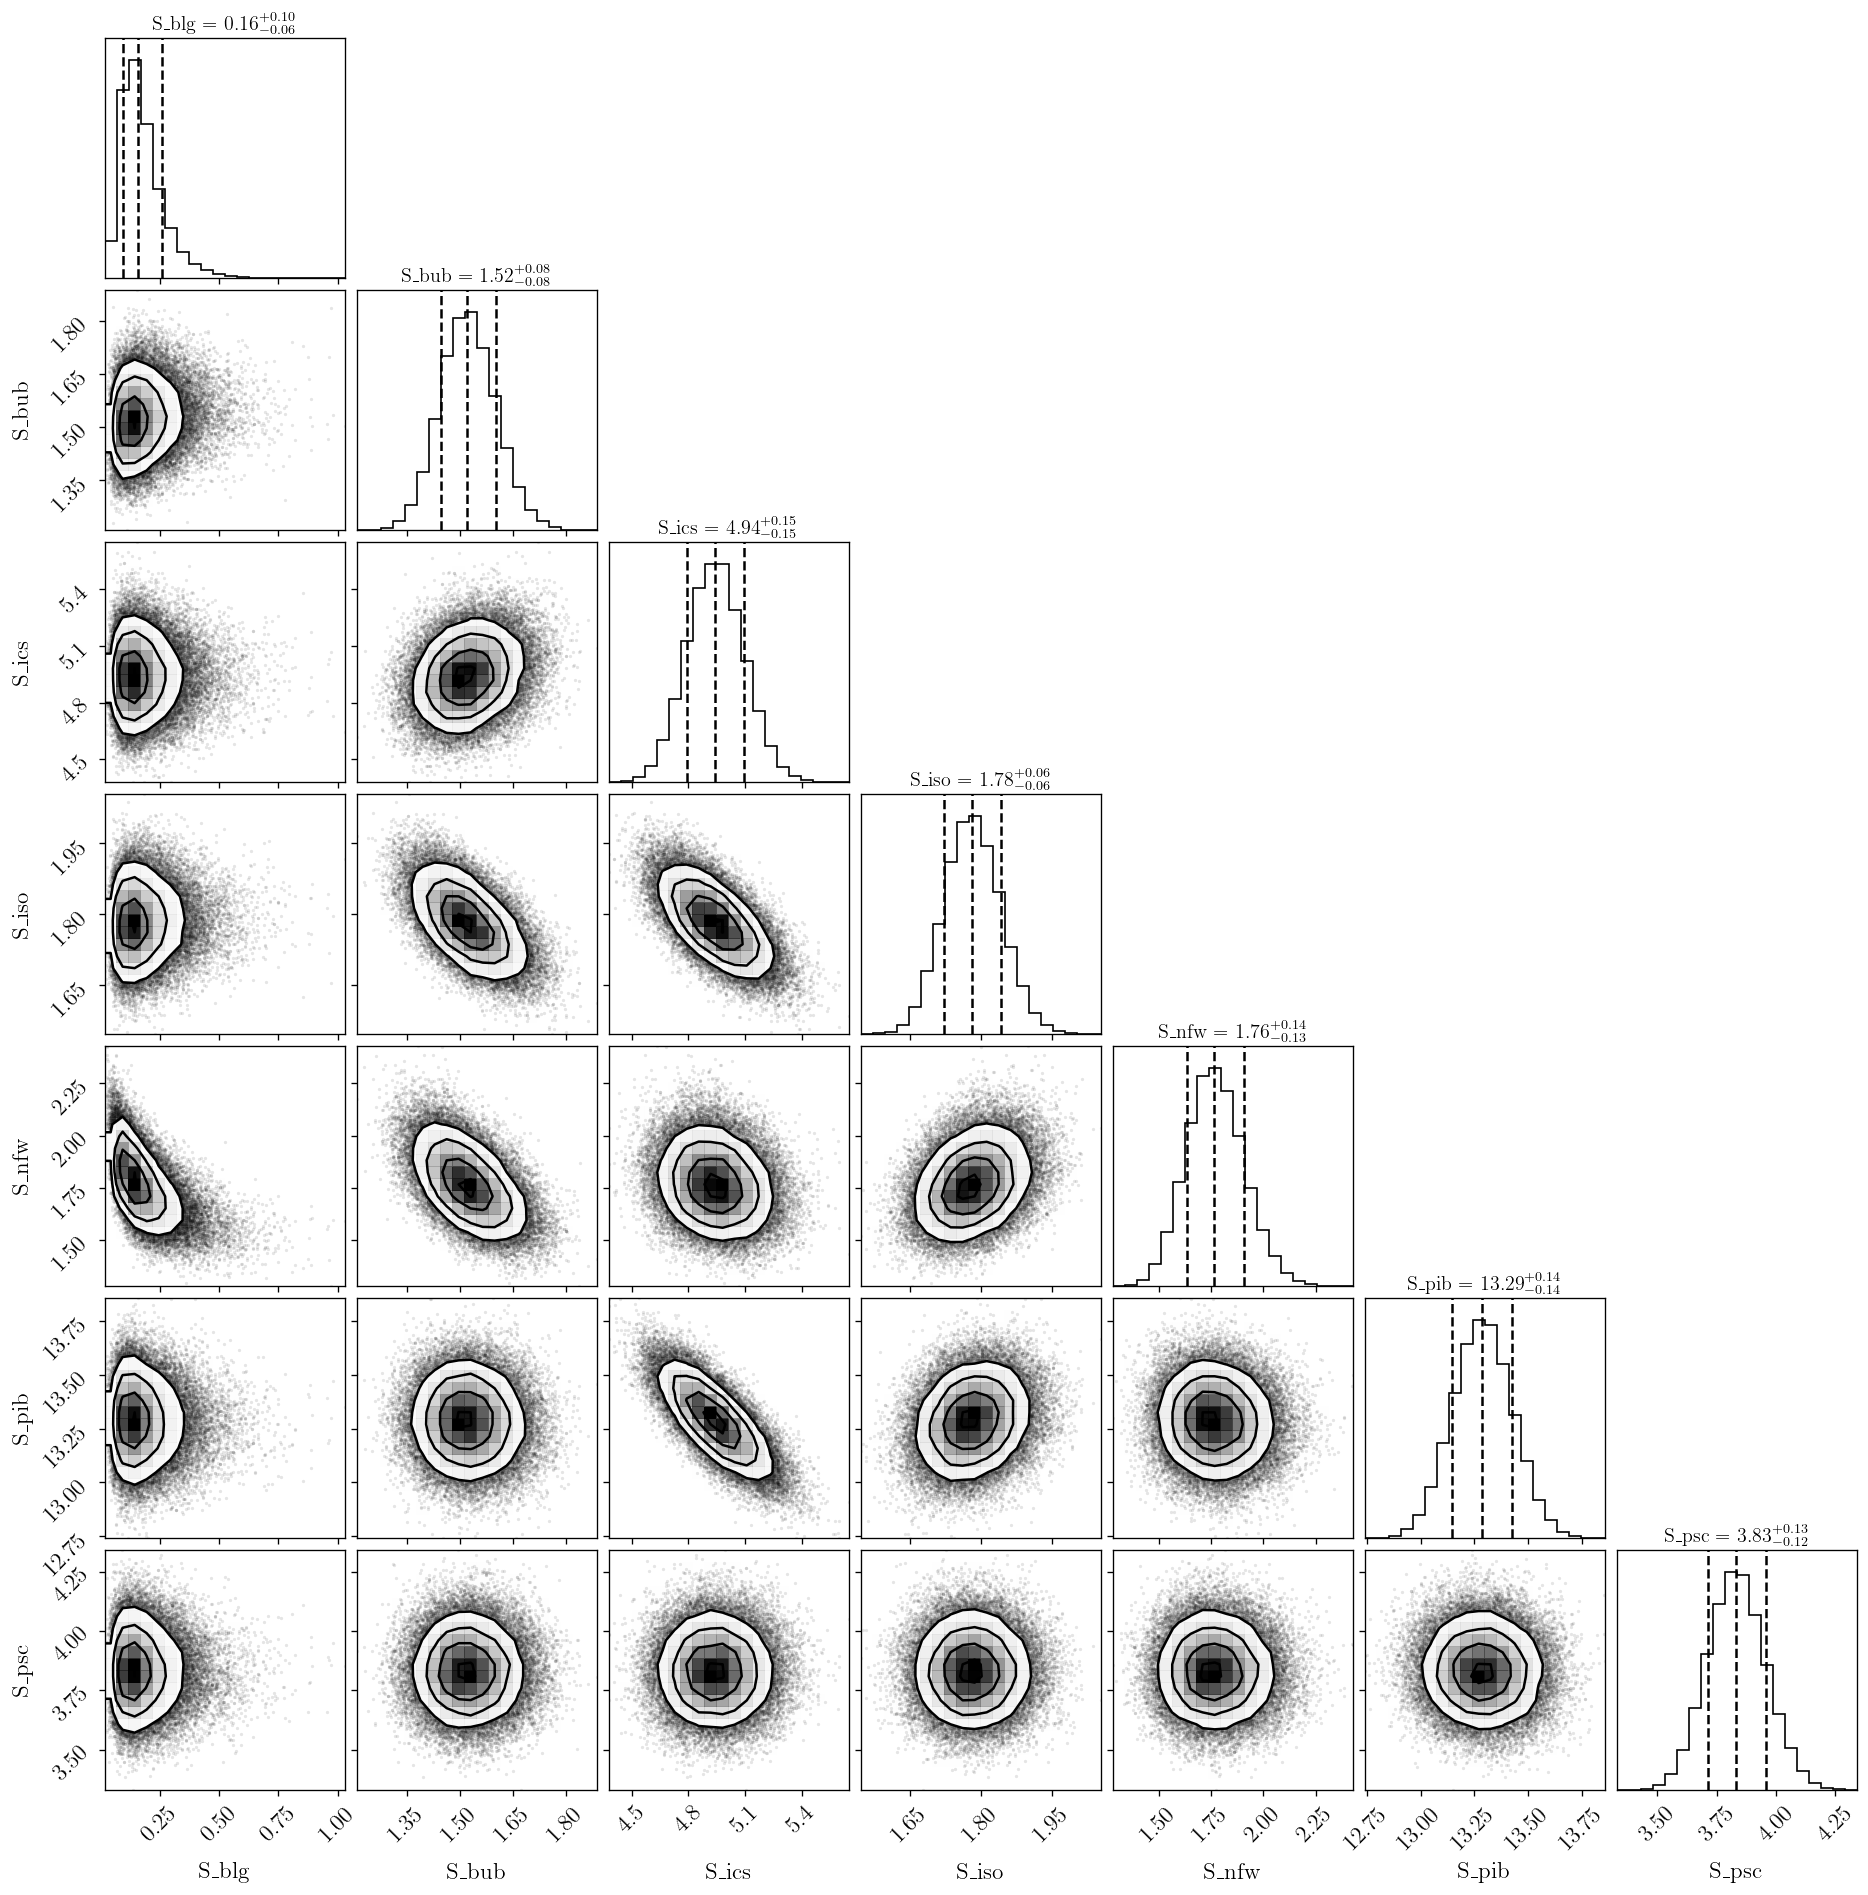

In [6]:
# generate corner plots of samples

fig = ef.make_corner_plots(samples)

Text(0, 0.5, 'log Loss')

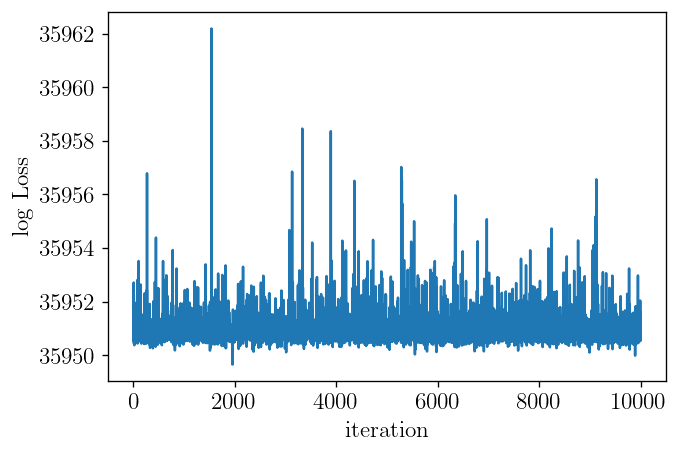

In [7]:
# loss vs step plot

plt.plot(svi_results.losses[90000:])
plt.xlabel('iteration')
plt.ylabel('log Loss')  

In [8]:
# save svi fit file
file_name = ('ebin' + str_ebin + '_smp_svi_' + 
             str_lr + '_' + str_n_steps + '_' + 
                str_guide + '_' + str_num_particles + '_' + str_svi_seed + '.p')
pickle.dump(
    (samples, svi_results), 
    open(data_dir + file_name, 'wb'))